In [147]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [145]:
nyc_sales_new = pd.read_csv('nyc-property-sales-new.csv')
print("The shape of the complete dataset is " + str(nyc_sales_new.shape))
nyc_sales_new['sale_date'] = pd.to_datetime(nyc_sales_new['sale_date'])
nyc_sales_new.set_index('sale_date', inplace=True)
df = pd.DataFrame(nyc_sales_new['sale_price'].resample('M').sum())


The shape of the complete dataset is (1937814, 19)


In [ ]:
def calculate_global_metrics(y_true, y_pred):
    """
    compute metrics
    """
    # Avoid division by zero for MAPE and SMAPE
    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
    
    # RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))
    
    # MSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return {"MAPE": mape, "SMAPE": smape, "RMSLE": rmsle, "RMSE": rmse}

### Total

In [ ]:
# Create the time series
train = df['2003-01-01':'2015-12-31']['sale_price']
test = df['2016-01-01':]['sale_price']

# Define the range of parameters for p, d, q to search over
p = [12]   # Set p as 12
q = range(0, 8)  
d = range(0, 1)  

P = range(0, 1) 
D = range(0, 1) 
Q = range(0, 1) 
m = 12  # Seasonal period (12 months for yearly seasonality)

# Generate all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all combinations of seasonal parameters
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_mse = np.inf
best_params = None
best_seasonal_params = None
best_model = None

# Grid search to find the best SARIMA hyperparameters using MSE
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the SARIMA model
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # Perform rolling one-step-ahead predictions on the test set
            history = list(train)
            predictions = []

            for t in range(len(test)):
                model = SARIMAX(history,
                                order=param,
                                seasonal_order=seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit(disp=False)
                yhat = results.forecast(steps=1)[0]
                predictions.append(yhat)
                history.append(test.iloc[t])

            # Calculate MSE
            mse = mean_squared_error(test, predictions)

            # Track the model with the lowest MSE
            if mse < best_mse:
                best_mse = mse
                best_params = param
                best_seasonal_params = seasonal_param
                best_model = results

        except Exception as e:
            print(f"Error fitting SARIMA with parameters {param} and seasonal {seasonal_param}: {e}")
            continue

# Display the best parameters found using MSE
print(f'Best SARIMA model: order={best_params}, seasonal_order={best_seasonal_params}, MSE={best_mse}')

Best SARIMA model: order=(12, 0, 7), seasonal_order=(0, 1, 1, 12)

In [ ]:
# Rolling one-step-ahead forecast for visualization
history = list(train)
predictions = []

for t in range(len(test)):
    # Fit the model on the current history (using all real data)
    model = SARIMAX(history,
                    order=best_params,
                    seasonal_order=best_seasonal_params,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)
    predictions.append(yhat[0])
    
    # Update the history with the actual observed value
    history.append(test.iloc[t])

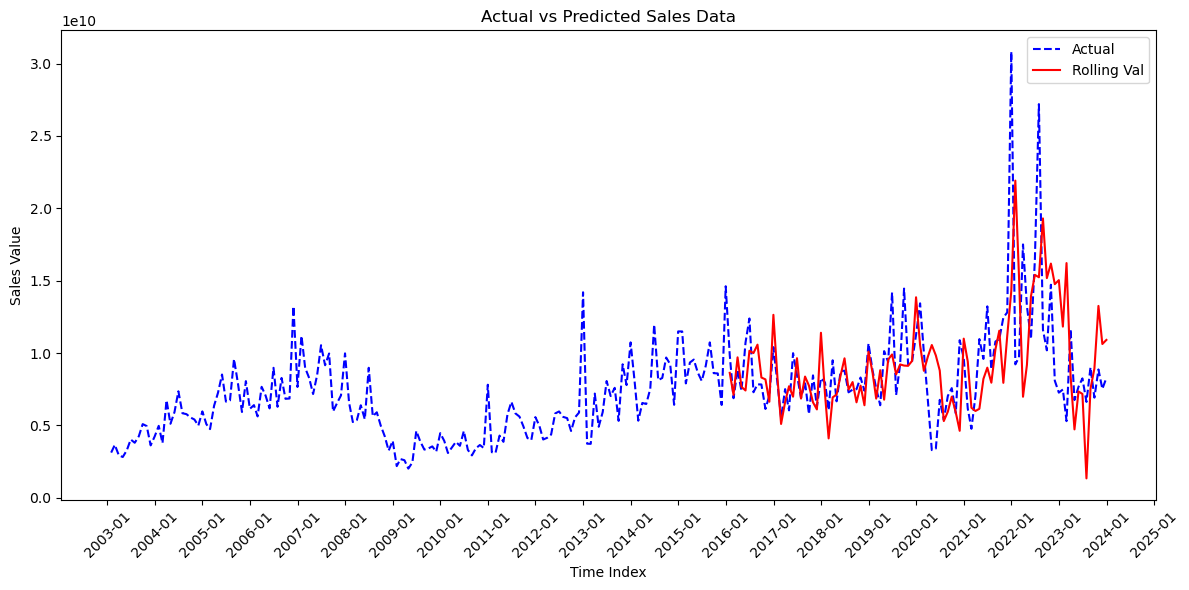

In [150]:
# Combine train, test, and predictions into a common dataframe for better plotting
temp = pd.concat([train, test], axis=0).reset_index()
temp['predictions'] = np.nan
temp.loc[len(train):, 'predictions'] = predictions

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

# Set the x-axis to display in yyyy-mm format
months = temp['sale_date']  # Using the date from the combined dataframe

# Plot actual values
plt.plot(months, temp['sale_price'], label='Actual', color='blue', linestyle='--')

# Plot predicted values for the test set
plt.plot(months[len(train):], temp['predictions'][len(train):], label='Rolling Val', color='red')

# Customize plot appearance
plt.title('Actual vs Predicted Sales Data')
plt.xlabel('Time Index')
plt.ylabel('Sales Value')

# Set date format for x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))  # Label every 12 months

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
calculate_global_metrics(test, predictions)